In [2]:
import sys, random
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.model_selection import TimeSeriesSplit ### для кросс-валидации временного ряда
from sklearn.linear_model import LinearRegression ### для модели линейной регрессии
from statsmodels.tsa.statespace.sarimax import SARIMAX ### для модели SARIMA
from statsmodels.tsa.seasonal import seasonal_decompose ### для выделения уровня, тренда и сезонности во временном ряду

from xgboost import XGBRegressor

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt

In [3]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
#init_notebook_mode(connected = True)

In [4]:
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [5]:
dataset = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/GeekBrains_seminar_26-01-2024/GB16~1.XLS', sheet_name=0)
dataset.head()

,Дата,Значение
0,2014-05-01,0
1,2014-05-02,10
2,2014-05-03,0
3,2014-05-04,0
4,2014-05-05,0


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Дата      1461 non-null   datetime64[ns]
 1   Значение  1461 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 23.0 KB


In [7]:
dataset.describe()

,Значение
count,1461.000000
mean,2.619439
std,2.624230
min,0.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,10.000000


In [8]:
ts_data = dataset.set_index('Дата')
ts_data.head(n=10)

,Значение
Дата,
2014-05-01,0
2014-05-02,10
2014-05-03,0
2014-05-04,0
2014-05-05,0
2014-05-06,0
2014-05-07,0
2014-05-08,0
2014-05-09,0


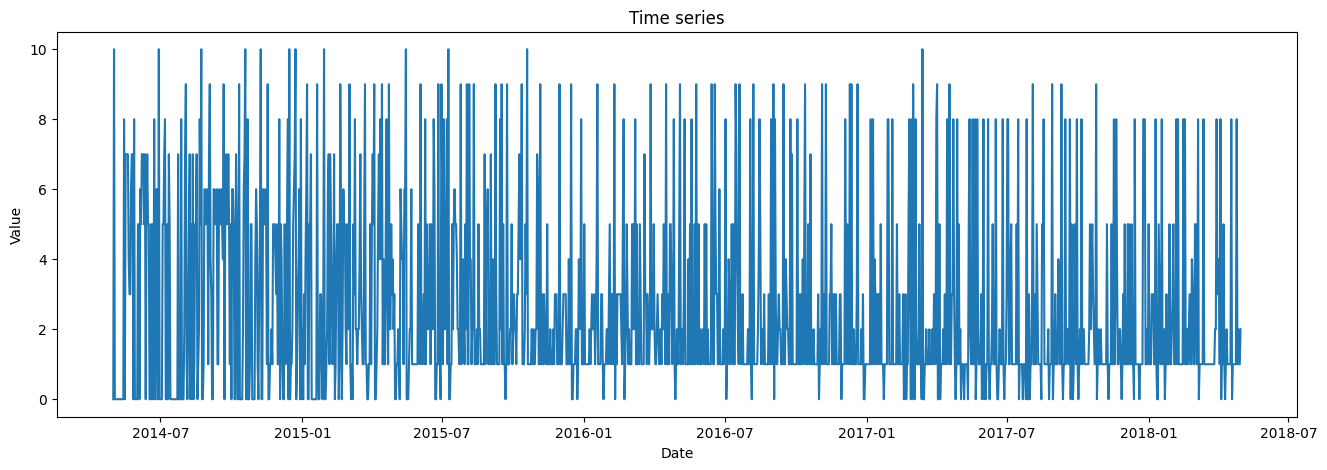

In [9]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(ts_data, x=ts_data.index, y=ts_data['Значение'], title='Time series')

In [10]:
### Rolling window estimations - скользящая средняя с окном n
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(ts_data, 7)

2.2857142857142856

In [11]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")

    #plt.plot(upper_bond, "g--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "g--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

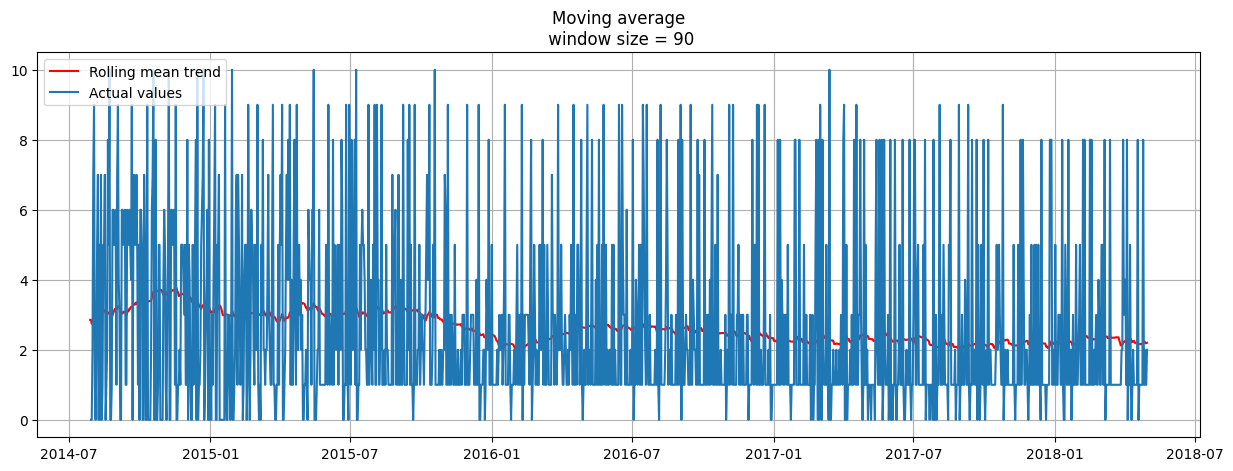

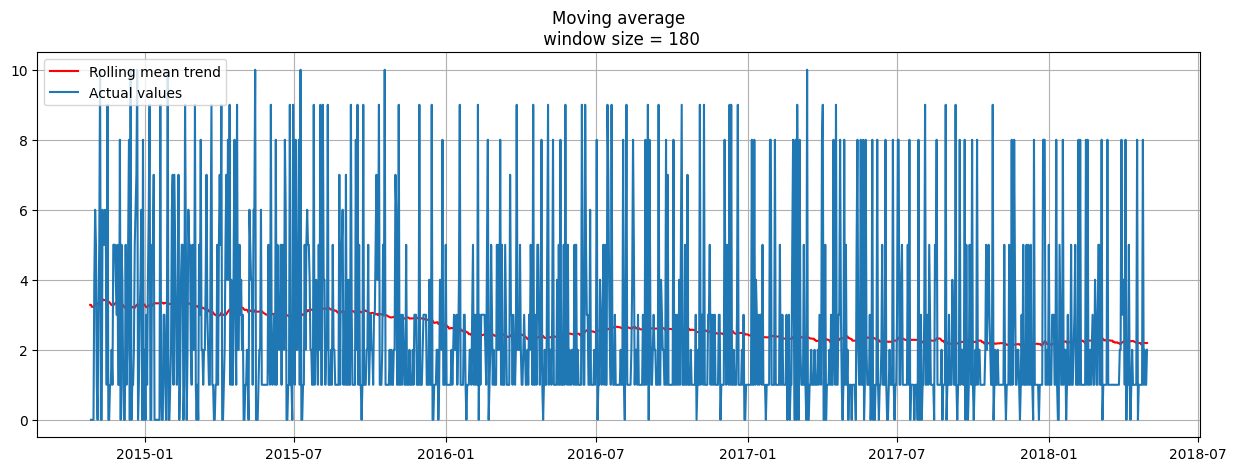

In [12]:
plotMovingAverage(ts_data, 30*3) # сглаживаем по четвертям года
plotMovingAverage(ts_data, 30*6) # сглаживаем по полугодьям

In [13]:
### Взвешанная скользящая средняя
def weighted_average(series, weights):
    result = 0.0
    #weights.reverse()
    for n in range(len(weights)):
        result += series['Значение'][n] * weights[n]
    return result

In [14]:
### генерирование и сортировка по возрастанию весов значений
weights = np.random.dirichlet(np.ones(ts_data.shape[0]),size=1)
weights.sum()
weights.sort()
print(weights)

[[2.91195511e-07 1.15134566e-06 1.35517116e-06 ... 4.44470882e-03
  4.56433666e-03 9.02991440e-03]]


In [15]:
weighted_average(ts_data, weights)

array([0., 0., 0., ..., 0., 0., 0.])

In [16]:
### Простое экспоненциальное сглаживание
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

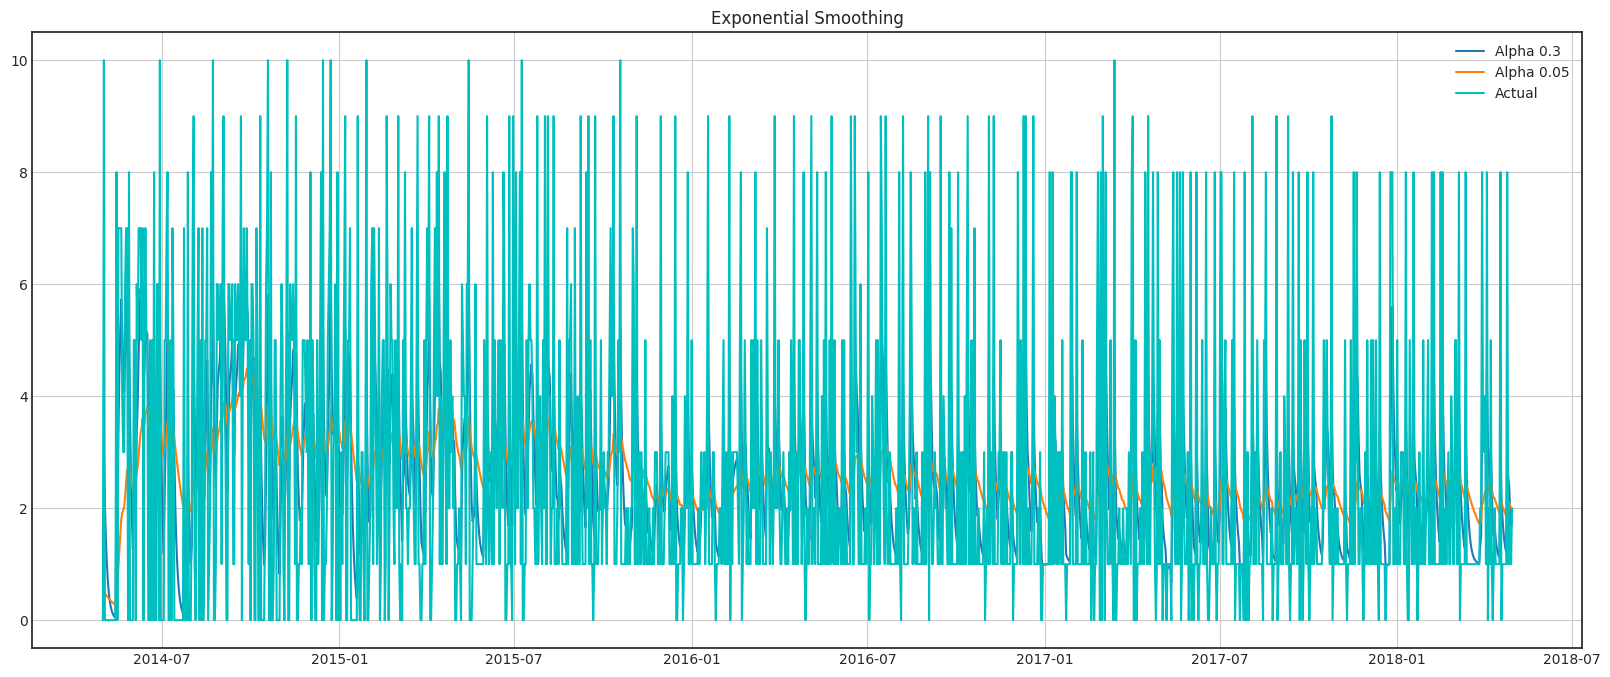

In [17]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(ts_data.index, exponential_smoothing(ts_data['Значение'], alpha), label="Alpha {}".format(alpha))
    plt.plot(ts_data, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

In [18]:
### Двойное экспоненциальное сглаживание
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

In [19]:
print(len(ts_data['Значение']))
print(len(double_exponential_smoothing(ts_data['Значение'], 0.9, 0.9)))

1461
1462


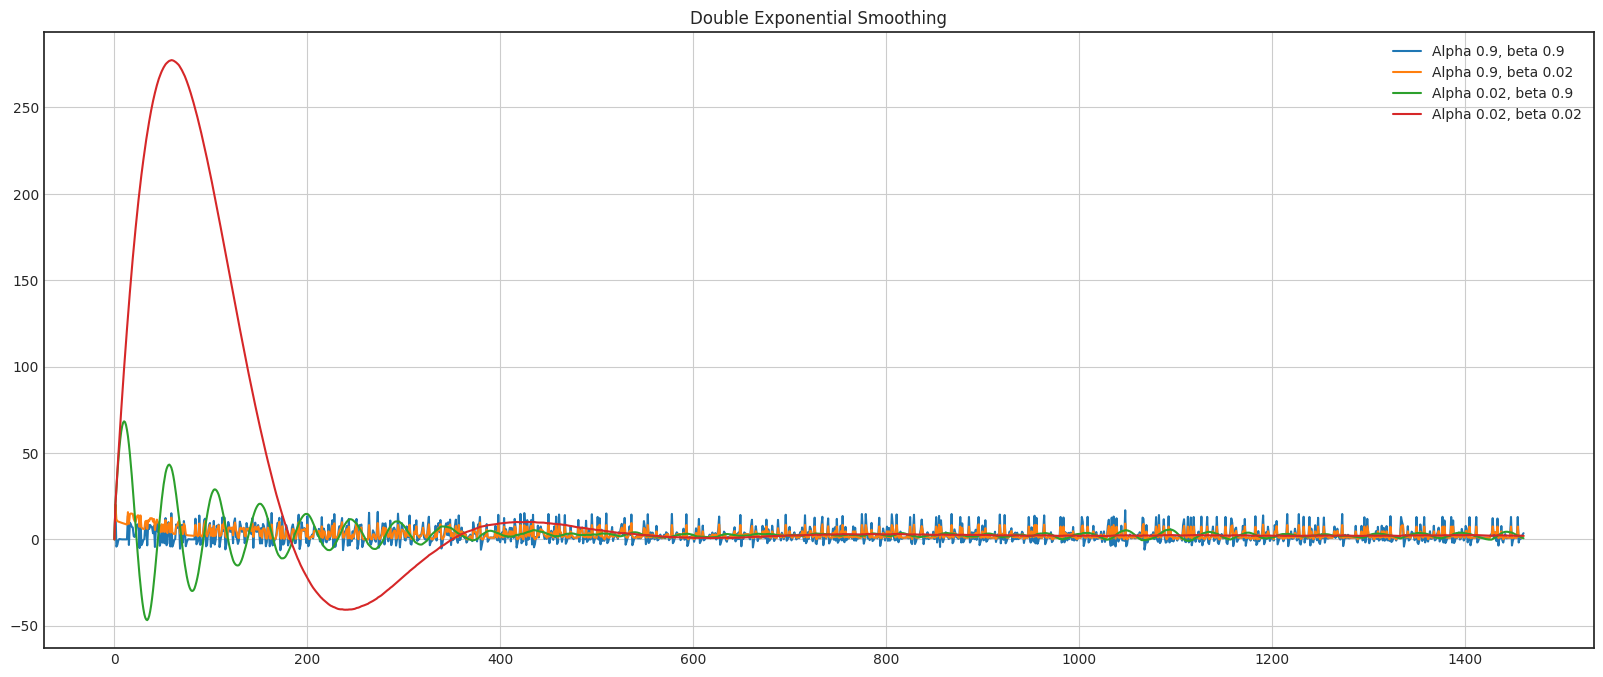

In [20]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(ts_data['Значение'], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    #plt.plot(ts_data.index, ts_data['Значение'], 'c', label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [21]:
### Тройное экспоненциальное сглаживание a.k.a. Holt-Winters

class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i])
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [22]:
### Кросс-валидация на временном ряду

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = ts_data['Значение']
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3)

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок
    return np.mean(np.array(errors))

In [23]:
### Подбор параметров

%%time
data = ts_data[:-500] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0]

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.015753092926066137 0.007494020801126378 0.01228521069287003
CPU times: user 30 s, sys: 98.3 ms, total: 30.1 s
Wall time: 39.8 s


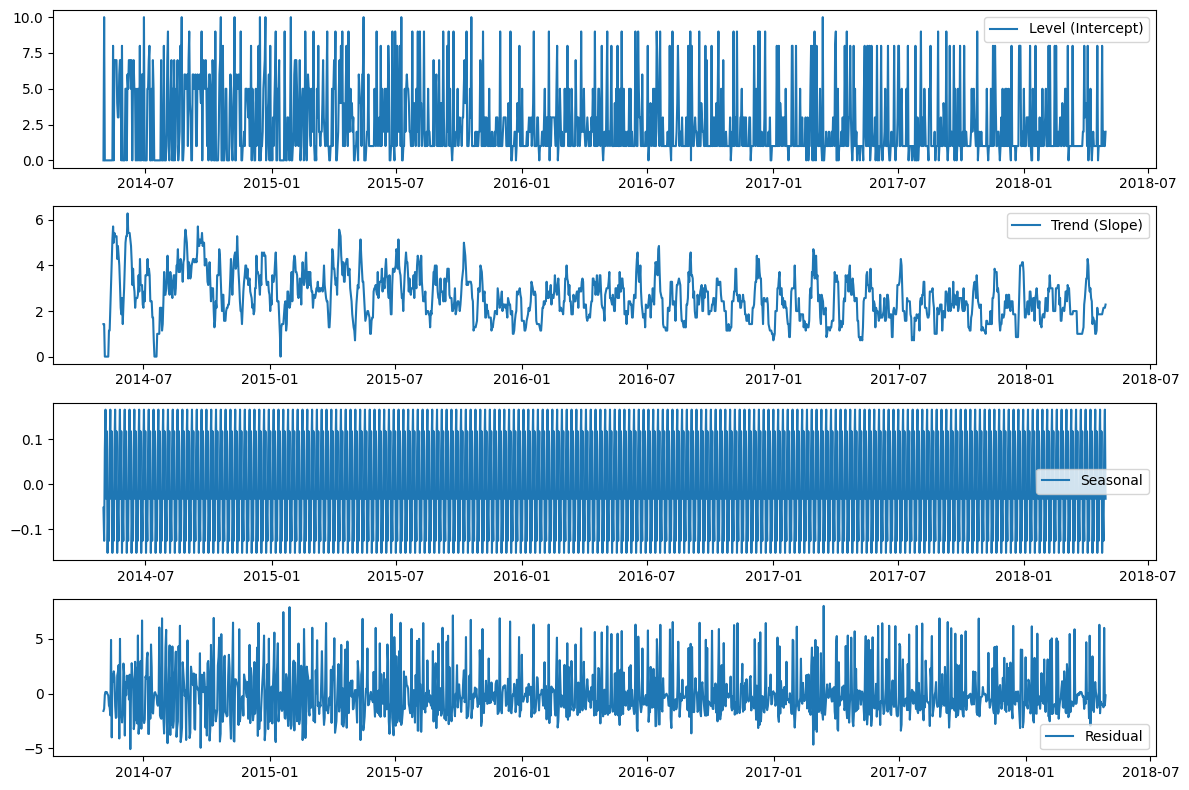

In [35]:
# Decompose the time series
result_Decompose = seasonal_decompose(ts_data['Значение'], model='additive')

# Plot the components
plt.figure(figsize=(12, 8))

# Plot the original time series
plt.subplot(4, 1, 1)
plt.plot(ts_data['Значение'], label='Level (Intercept)')
plt.legend(loc='best')

# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(result_Decompose.trend, label='Trend (Slope)')
plt.legend(loc='best')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(result_Decompose.seasonal, label='Seasonal')
plt.legend(loc='best')

# Plot the residual component
plt.subplot(4, 1, 4)
plt.plot(result_Decompose.resid, label='Residual')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

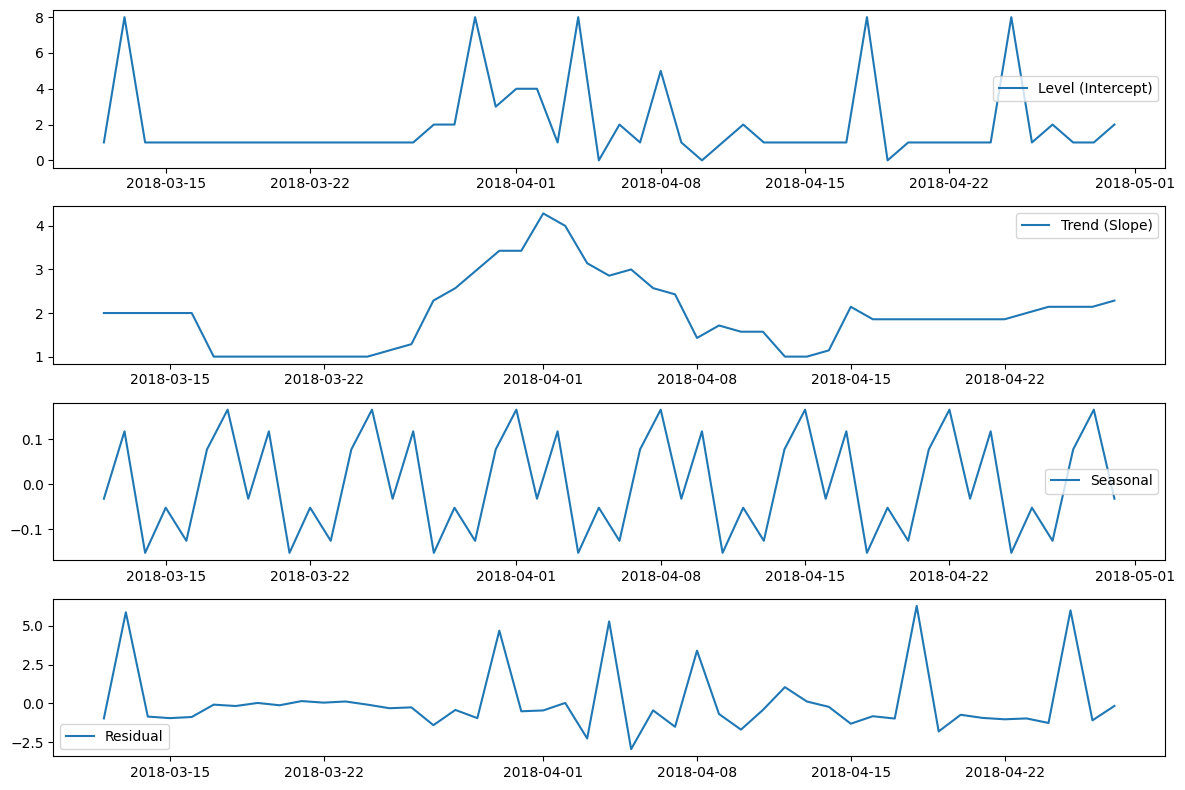

In [39]:
### Отрисовка 50 последних значений временного ряда
# Plot the components
plt.figure(figsize=(12, 8))

# Plot the original time series
plt.subplot(4, 1, 1)
plt.plot(ts_data['Значение'].tail(50), label='Level (Intercept)')
plt.legend(loc='best')

# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(result_Decompose.trend.tail(50), label='Trend (Slope)')
plt.legend(loc='best')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(result_Decompose.seasonal.tail(50), label='Seasonal')
plt.legend(loc='best')

# Plot the residual component
plt.subplot(4, 1, 4)
plt.plot(result_Decompose.resid.tail(50), label='Residual')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [24]:
# Передаем оптимальные значения модели,
data = ts_data['Значение']
model = HoltWinters(data[:-128], slen = 7, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 128, scaling_factor = 2.56)
model.triple_exponential_smoothing()

In [26]:
### Проверка стационарности временного ряда
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return

Критерий Дики-Фуллера: p=0.000000


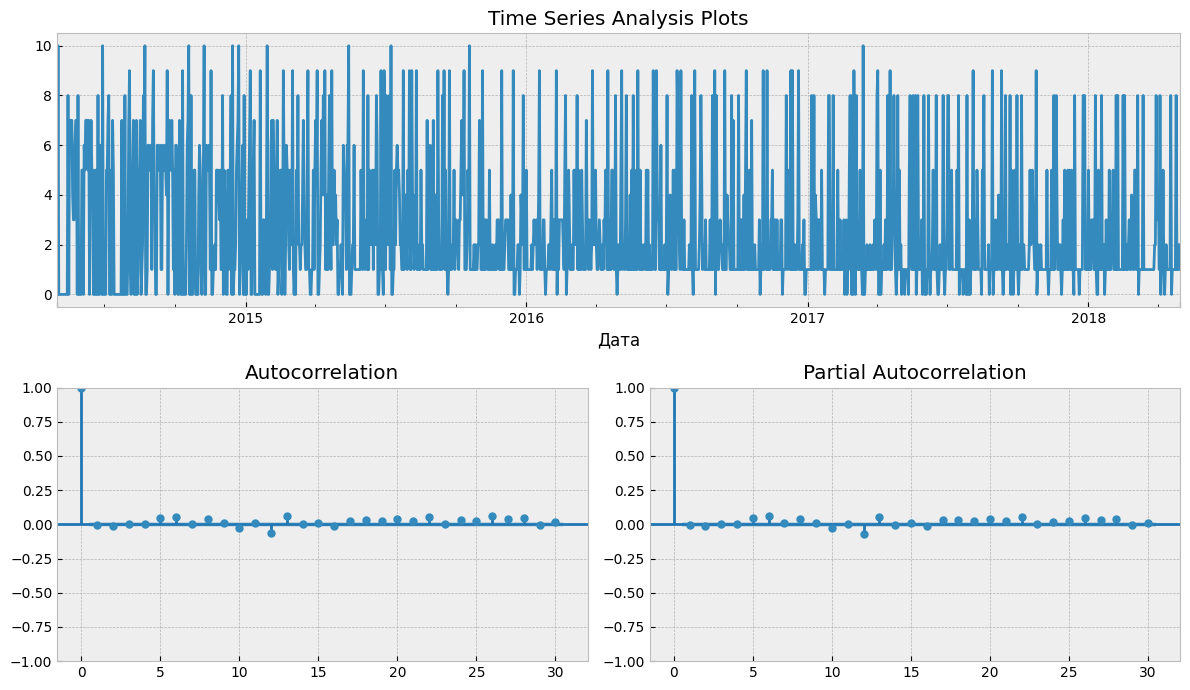

In [27]:
tsplot(ts_data['Значение'], lags=30)

Построение SARIMA модели

In [28]:
### Определение параметров модели
order = (1, 1, 1) ### (p, d, q)  - несезонные параметры
seasonal_order = (1, 1, 1, 7) ### (P, D, Q, s) -  сезонные параметры

# Create the SARIMA model
model_sarima = SARIMAX(ts_data['Значение'], order=order, seasonal_order=seasonal_order)

# Fit the model to the data
results_sarima = model_sarima.fit()

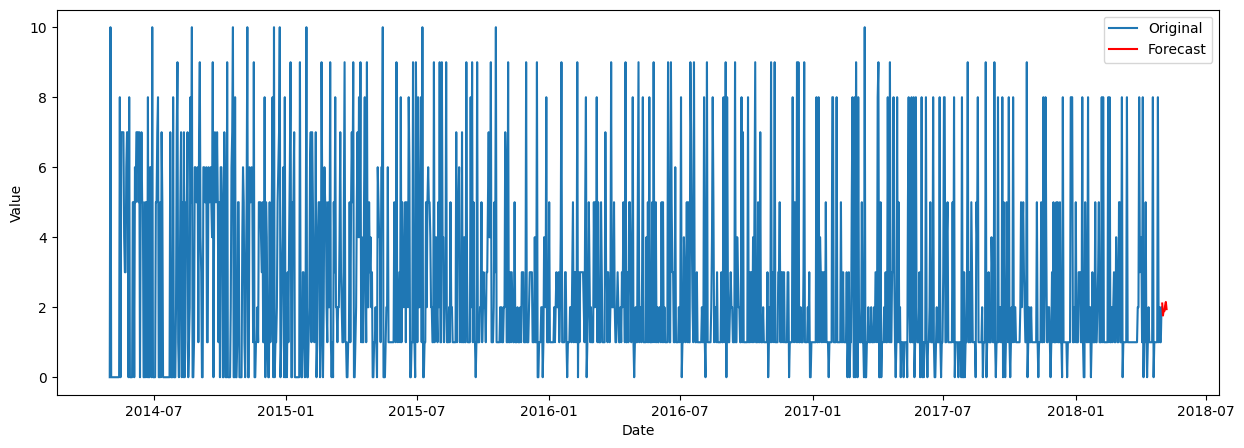

In [29]:
# Прогнозирование будущих значений
forecast = results_sarima.forecast(steps = 7)  # прогноз на 7 дней

### Отрисовка полного графика
plt.figure(figsize=(15,5))
plt.plot(ts_data, label='Original')
plt.plot(forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

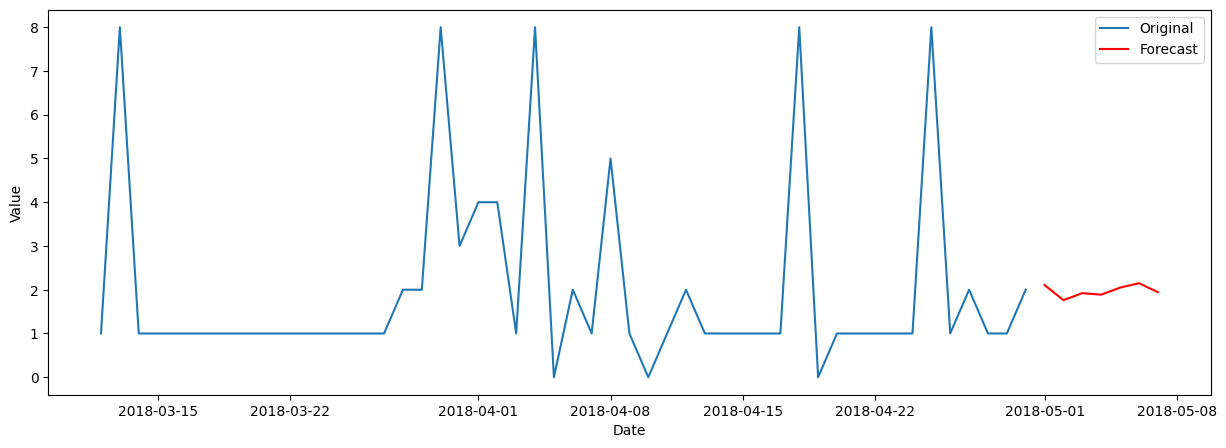

In [30]:
### Отрисовка 50 последних значений графика
plt.figure(figsize=(15,5))
plt.plot(ts_data.tail(50), label='Original')
plt.plot(forecast, label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

Построение прогноза при помощи XGBoost

Root Mean Squared Error (RMSE): 3.189161178387121e-05


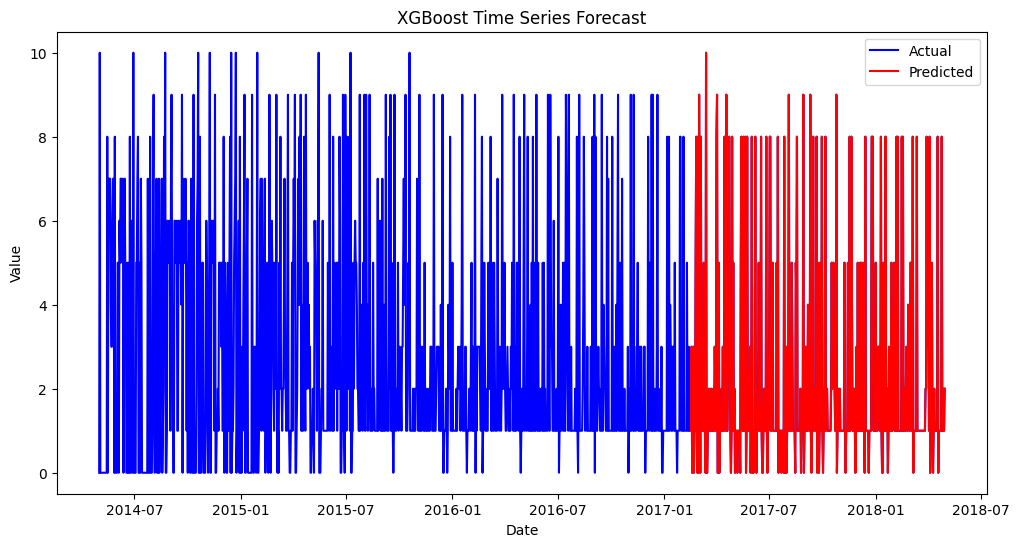

In [31]:

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(ts_data, ts_data['Значение'], test_size=0.3, shuffle=False)

# Step 3: Build the XGBoost model
model_XGB = XGBRegressor(n_estimators=100, objective='reg:squarederror')

# Step 4: Train the model
model_XGB.fit(X_train, y_train)

# Step 5: Make predictions
y_pred = model_XGB.predict(X_test)

# Step 6: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Step 7: Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index, ts_data['Значение'], 'b', label='Actual')
plt.plot(y_test.index, y_pred, 'r', label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('XGBoost Time Series Forecast')
plt.show()
